In [ ]:
# can be removed if LinOT package is installed via pip
import sys
sys.path.append('../../lib')

import os
import numpy as np

import LinOT
from LinOT.Visualization import *
import LinOT.auxiliary as aux
import LinOT.SinkhornNP as Sinkhorn

import json

from libSphere.Riem_Sphere import *
from libSphere.Visualization import *

# Analysis of disks on a sphere

## Preprocessing / loading data

In [2]:
dataDir="data/RotatingCircleOnSphere/"

fileSamples=dataDir+'sampleDisks.npz'
fileCenter=dataDir+'centerTan.npz'

fileTan=dataDir + 'tan_data_HK.npz'
fileParams=dataDir + 'params.json'

In [3]:
R=1
nNus=20

loadedSamples=np.load(fileSamples)
posNus=list(loadedSamples.values())
nus=[np.ones(pts.shape[0])/pts.shape[0] for pts in posNus]

posMu=np.load(fileCenter)['posMu']
mu=np.ones(posMu.shape[0])/posMu.shape[0]

with open(fileParams,'r') as fp:
    params=json.load(fp)

print(params)

tanListV,tanListAlpha=list(np.load(fileTan).values())

baseExp=lambda x,v:expX(x,v,rad=R)

{'setup_HKScale': 4, 'solver_errorGoal': 1e-06, 'solver_epsStart': 100.0, 'solver_epsTarget': 0.0001}


### Visualize reference measure and some samples

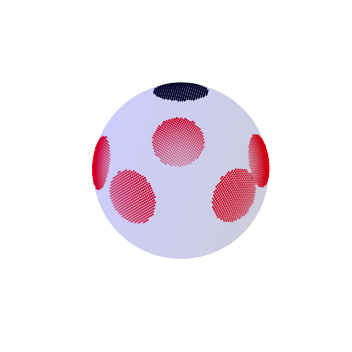

In [4]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

i = 0

plotSphere(ax,R,.1)

ax.scatter(posMu[:,0],posMu[:,1],posMu[:,2],c='k',s=1)

for posNu in posNus[::4]:
    ax.scatter(posNu[:,0],posNu[:,1],posNu[:,2],c='red',s=1)
    i+=1

ax.set_box_aspect((1, 1, 1))
ax.view_init(elev=21, azim=-56)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Create linear embedding classes

In [6]:
embHK=LinOT.LinHKEmbedding(muRef=mu,posRef=posMu,\
        kappa=params['setup_HKScale'],baseExp=baseExp)
embSHK=LinOT.LinSHKEmbedding(muRef=mu,posRef=posMu,\
        kappa=params['setup_HKScale'],baseExp=baseExp)

embHK.addSamples((tanListV,tanListAlpha))
embHK.centerSamples()

embSHK.addSamples((tanListV,tanListAlpha),fromHK=True)
embSHK.centerSamples()

### Visualize exponential map on samples

In [8]:
fig=plt.figure(figsize=(7,7))
ax=fig.add_subplot(projection="3d")
for sample in embHK.samples[::4]:
    muExp,posExp=embHK.expEuclidean(sample)
    ax.scatter(posExp[:,0],posExp[:,1],posExp[:,2],c='r',s=1)
plotSphere(ax,R,.1)
ax.set_box_aspect((1,1,1))
ax.set_axis_off()
plt.tight_layout()
plt.show()

## PCA Analysis

### Spectra

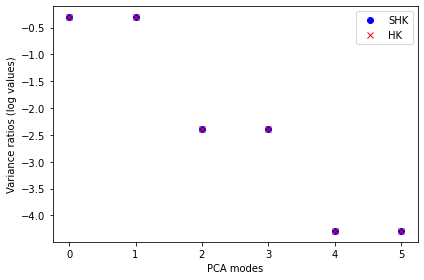

In [9]:
keep=6

embHK.performPCA(keepDim=keep)
embSHK.performPCA(keepDim=keep)

ratiosHK=embHK.pca_var/sum(embHK.pca_var)
ratiosSHK=embSHK.pca_var/sum(embSHK.pca_var)

plt.plot(np.arange(keep),np.log10(ratiosSHK),marker="o", c='b',lw=0,label='SHK')
plt.plot(np.arange(keep),np.log10(ratiosHK),marker="x", c='r',lw=0,label='HK')
plt.xticks(np.arange(keep))
plt.ylabel('Variance ratios (log values)')
plt.xlabel('PCA modes')
plt.legend()
plt.tight_layout()
plt.show()

### Show PCA embeddings

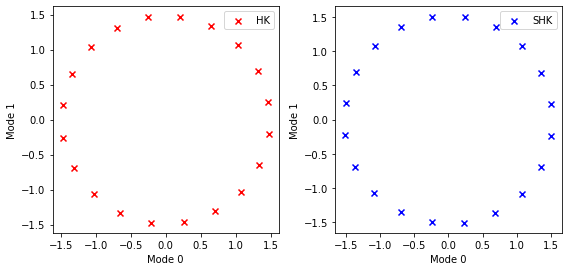

In [10]:
fig=plt.figure(figsize=(8,4),facecolor="white")

fig.add_subplot(1,2,1,aspect=1.)
plt.scatter(embHK.pca_coords[:,0],embHK.pca_coords[:,1],marker='x',c='r',label="HK")
plt.xlabel('Mode 0')
plt.ylabel('Mode 1')
plt.legend()

fig.add_subplot(1,2,2,aspect=1.)
plt.scatter(embSHK.pca_coords[:,0],embSHK.pca_coords[:,1],marker='x',c='b',label="SHK")
plt.xlabel('Mode 0')
plt.ylabel('Mode 1')
plt.legend()

plt.tight_layout()
plt.show()

## Rasterization of exponential maps

In [11]:
nPtsViz=4000
vertMeshViz=sampleFromSphere(nPtsViz)
vertMeshViz*=R
sigma=.002

kernel=lambda x,grid,sigma:aux.kernelSphere(x,grid,sigma,rad=R)

### Linearized mean: HK

In [12]:
# mean and rasterization
muMean,posMuMean=embSHK.getMeanExp()

# rasterization
muMeanPlots=aux.kde(posMuMean,muMean,vertMeshViz,sigma=sigma,kernel=kernel)

<IPython.core.display.Javascript object>


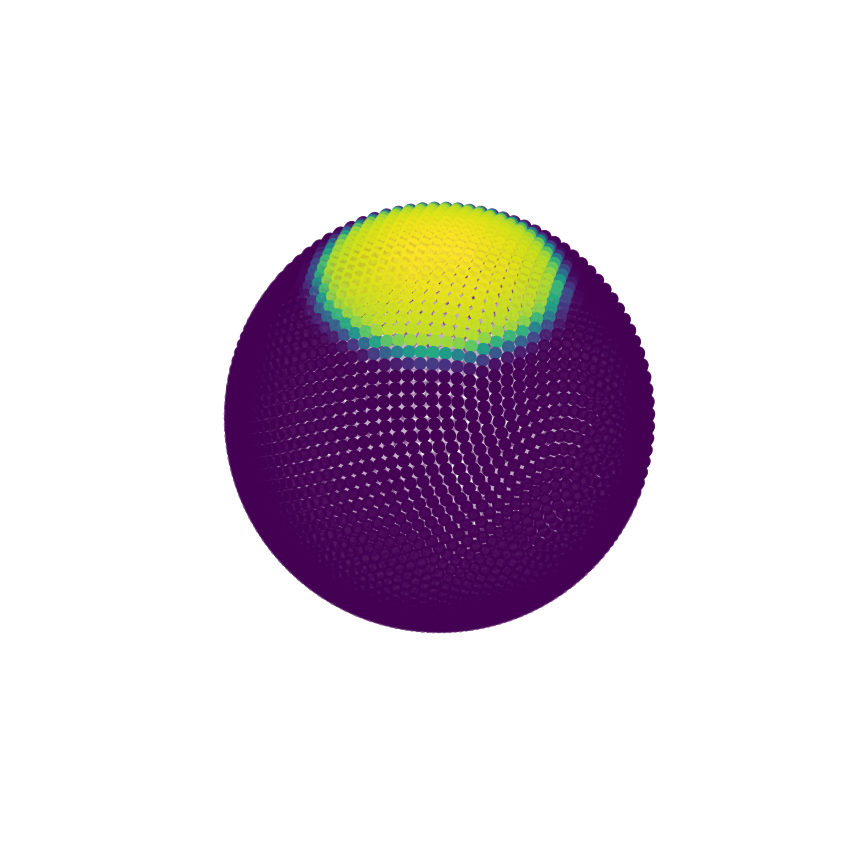

In [13]:
%matplotlib notebook

fig=plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')

p=ax.scatter(*(vertMeshViz.transpose()),c=muMeanPlots)

ax.set_box_aspect((1, 1, 1))
ax.view_init(elev=39, azim=42)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [14]:
# Support of nuMean to check visually for density variations

%matplotlib notebook

fig=plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')

p=ax.scatter(*(posMuMean.transpose()),c=muMean,s=5.)
plotSphere(ax,rad=R,alpha=0.1)
ax.set_box_aspect((1, 1, 1))
ax.view_init(elev=88, azim=42)
ax.set_axis_off()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

### Shoot along PCA modes: HK

In [15]:
# along how many modes to shoot
keepShoot=2
# how many steps for each mode
nSteps=5
# direction for each shot
directions=np.identity(keep)

timeSteps=np.linspace(-1,1,num=nSteps)

muBPlots=np.zeros((keepShoot,nSteps,nPtsViz))
mass=np.zeros((keepShoot,nSteps))
for i in range(keepShoot):
    shooting=embHK.expPCA(v=directions[i],tSeq=timeSteps*embHK.pca_std[i])
    for j, (muB,posB) in enumerate(shooting):
        muBPlots[i,j]=aux.kde(posB,muB,vertMeshViz,sigma=sigma,kernel=kernel)
        mass[i,j]=np.sum(muB)
    # normalize all images in current row
    muBPlots[i]=muBPlots[i]/np.max(muBPlots[i])

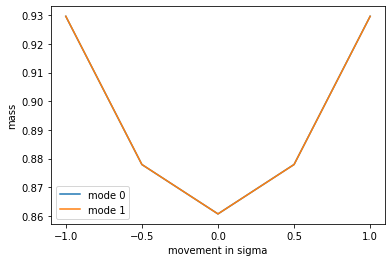

In [16]:
# mass along shooting curves
%matplotlib inline

for i in range(keepShoot):
    plt.plot([-1,-.5,0,.5,1],mass[i],c=cm.tab10(i),label=f"mode {i}")
plt.xticks([-1,-0.5,0,0.5,1])
plt.xlabel("movement in sigma")
plt.ylabel("mass")
plt.legend()
plt.show()

In [17]:
np.linalg.norm(embHK.pca_vec,axis=1)

array([1., 1., 1., 1., 1., 1.])

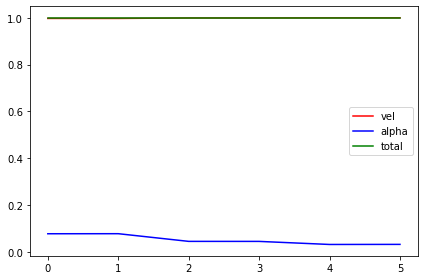

In [39]:
# transport and growth contributions to norm of PCA eigenvectors
normVs=[]
normAlphas=[]
normTotals=[]

for vec in embHK.pca_vec[:keep]:
    vel,alpha=embHK.convertEuclideanToRaw(vec,shiftMean=False)
    normV=np.einsum('ik,i->',vel**2,mu)
    normV=np.sqrt(normV)
    normVs.append(normV)
    normAlpha=np.einsum('i,i->',alpha**2,mu)*params["setup_HKScale"]**2/4
    normAlpha=np.sqrt(normAlpha)
    normAlphas.append(normAlpha)
    normTotal=np.sqrt(normAlpha**2+normV**2)
    normTotals.append(normTotal)
#print(normVs)
#print(normAlphas)
plt.plot(range(keep),normVs,c='r',label="vel")
plt.plot(range(keep),normAlphas,c='b',label="alpha")
plt.plot(range(keep),normTotals,c='g',label="total")
plt.legend()
plt.tight_layout()
plt.show()

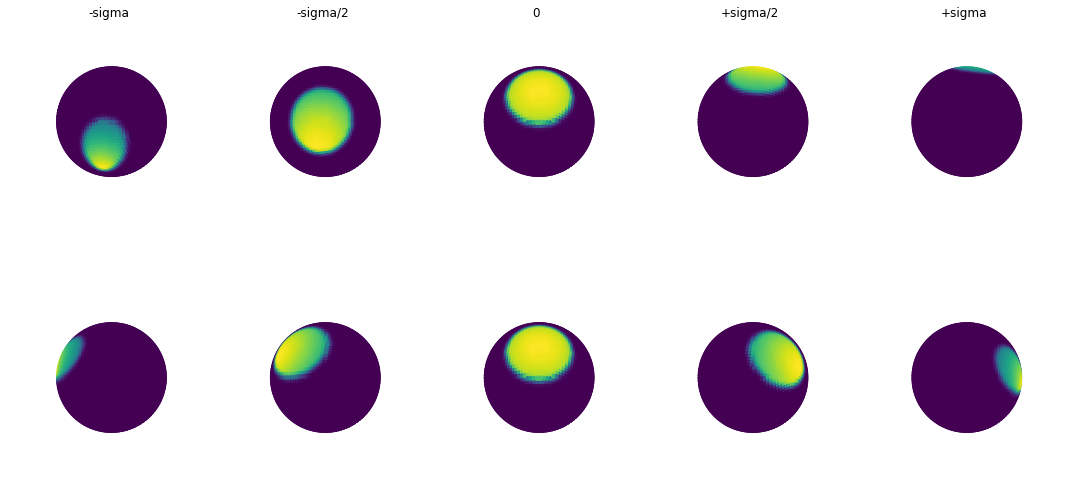

In [40]:
titleList=["-sigma","-sigma/2","0","+sigma/2","+sigma"]

fig=plt.figure(figsize=(15,8))
for i in range(keepShoot):
    for (j,t) in enumerate(timeSteps):
        ax=fig.add_subplot(keepShoot,nSteps,i*nSteps+j+1,projection='3d')
        ax.scatter(*(vertMeshViz.transpose()),c=muBPlots[i,j])
        ax.set_box_aspect((1, 1, 1))
        ax.view_init(elev=57, azim=37)
        ax.set_axis_off()

        if i==0:
            plt.title(titleList[j])
plt.tight_layout()
plt.show()